In [19]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import os
import cv2
import pandas as pd
from skimage import io
from torch.optim.lr_scheduler import StepLR

# import scripts
from scripts.saveResults import  *
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

Dataset 

In [20]:

class SolarRadiance(Dataset):
    def __init__(self, root_dir, labels, transform):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        # self.data = self.load_dataset()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = self.labels.iloc[index,0]
        target = self.labels.iloc[index,1]

        image = io.imread(img_path)
        image = cv2.imread(img_path)#, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (60, 80))

        if self.transform:
             image = self.transform(image)

        y_label = torch.tensor(target)

        return image, y_label

In [21]:
def load_dataset(root_dir):
        ds = pd.DataFrame()
        dates = os.listdir(root_dir)

        try:
            for date in dates:
                infrared_folder = os.path.join(root_dir, date, "infrared")
                pyranometer_folder = os.path.join(root_dir, date, "pyranometer")
                csv_path = os.path.join(pyranometer_folder, "{date}.csv".format(date=date))
                if not os.path.exists(csv_path):
                    print("Skipping date {date} because it does not have both infrared and pyranometer folders".format(date=date))
                    continue
                ds_temp = getDs(infrared_folder, csv_path)
                
                # append the dataframe in the final dataframe
                # ds = ds.append(ds_temp)
                ds = pd.concat([ds, ds_temp], ignore_index=True)

                ds['name'] = ds['name'].apply(lambda img: os.path.join(root_dir, date, 'infrared', img))
        except Exception as e:
            print(e)
        return ds

def getDs(path, labels):
    pyranometer = pd.read_csv(labels)
    images = os.listdir(path)
    
   
    #convert column 1 to int
    X = pyranometer.iloc[:,0].astype(int)

    #convert to image names
    pyranometer.iloc[:,0] = X.apply(lambda x: str(x) + 'IR.png')
    
    # Filter pyranometer DataFrame based on the 'x' column

    filtered_pyranometer = pyranometer[pyranometer.iloc[:,0].isin(images)]
    # Display the result
    filtered_pyranometer.columns = ['name', 'value']

    filtered_pyranometer = filtered_pyranometer.drop_duplicates(subset='name')
    return filtered_pyranometer


In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Data

In [23]:

# Hyperparameters
in_channel = 1
batch_size = 50
num_epochs = 50
loss = 1 # if loss = 0 the model will be trained with RMSE loss and vice versa
lr=0.01 # learning rate

# create result directory
result_dir = 'result/teacher'

In [24]:
result_dir 

'result/teacher'

In [25]:
random_seed = 42

In [26]:
train_dir = 'F:/Girasol/extracted/train/'
train_data  = load_dataset(train_dir)
torch.manual_seed(random_seed)
train_set = SolarRadiance(root_dir= train_dir, labels=train_data, transform = transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

val_dir = 'F:/Girasol/extracted/val/'
val_data  = load_dataset(val_dir)
torch.manual_seed(random_seed)
random_seed = 42
val_set = SolarRadiance(root_dir= val_dir, labels=val_data, transform = transforms.Compose([transforms.ToTensor()]))
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

Model

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained MobileNet model without its final classification layer
mobilenet = models.mobilenet_v2(pretrained=True)
# Remove the last layer (classification layer)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

# Add custom layers for regression
class LinearRegressionHead(nn.Module):
    def __init__(self, in_features):
        super(LinearRegressionHead, self).__init__()
        self.fc = nn.Linear(in_features, 1)  # Output 1 value for linear regression
    
    def forward(self, x):
        x = self.fc(x)
        return x

# Append the custom regression head to the pre-trained model
in_features = mobilenet[-1][-1].out_channels  # Get the number of output channels from the last layer
model = nn.Sequential(
    mobilenet,
    nn.AdaptiveAvgPool2d(1),  
    nn.Flatten(),
    LinearRegressionHead(in_features)
)
model.to(device)
# Example usage:
# input_data = torch.randn(1, 3, 224, 224)  # Example input data with 3 channels (RGB) and 224x224 size
# output = model(input_data)

c:\Users\nijhu\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nijhu\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1

Loss and Optimizers

In [28]:
if loss == 0:
    # create a function (this my favorite choice)
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss
else:
    # Define the model, loss function, and optimizer
    criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a StepLR scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# set initial loswest_loss to an infinite number
lowest_loss = 10000000


In [29]:
losses = []

from tqdm import tqdm
# Train the model
for epoch in range(num_epochs):
    scheduler.step()
    print('Epoch ',epoch)
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        # Zero the gradients
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs[:,0], targets.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test data
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs[:,0], targets.float())
            total_loss += loss.item()
        mean_loss = total_loss / len(val_loader)
        print(f'val Loss: {mean_loss:.4f}')
        losses.append(mean_loss)
        if  mean_loss<lowest_loss:
            print('mean_loss '+str(mean_loss)+'lowest_loss'+str(lowest_loss))
            lowest_loss = mean_loss
            torch.save(model.state_dict(), os.path.join(result_dir,'teacher.pth'))
            

c:\Users\nijhu\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch  0


100%|██████████| 931/931 [05:56<00:00,  2.61it/s]


val Loss: 2460.4130
mean_loss 2460.4130196406923lowest_loss10000000
Epoch  1


100%|██████████| 931/931 [02:13<00:00,  6.98it/s]


val Loss: 2397.0911
mean_loss 2397.091097075364lowest_loss2460.4130196406923
Epoch  2


100%|██████████| 931/931 [02:16<00:00,  6.82it/s]


val Loss: 2193.7916
mean_loss 2193.791599931388lowest_loss2397.091097075364
Epoch  3


100%|██████████| 931/931 [02:18<00:00,  6.71it/s]


val Loss: 2255.2980
Epoch  4


100%|██████████| 931/931 [02:22<00:00,  6.52it/s]


val Loss: 2110.9859
mean_loss 2110.985855102539lowest_loss2193.791599931388
Epoch  5


100%|██████████| 931/931 [02:21<00:00,  6.59it/s]


val Loss: 2088.0493
mean_loss 2088.049296148892lowest_loss2110.985855102539
Epoch  6


100%|██████████| 931/931 [02:22<00:00,  6.54it/s]


val Loss: 1970.7537
mean_loss 1970.7536931531183lowest_loss2088.049296148892
Epoch  7


100%|██████████| 931/931 [02:22<00:00,  6.52it/s]


val Loss: 2020.3211
Epoch  8


100%|██████████| 931/931 [02:26<00:00,  6.37it/s]


val Loss: 1991.7829
Epoch  9


100%|██████████| 931/931 [02:25<00:00,  6.38it/s]


val Loss: 2003.1829
Epoch  10


100%|██████████| 931/931 [02:27<00:00,  6.32it/s]


val Loss: 1972.3091
Epoch  11


100%|██████████| 931/931 [02:24<00:00,  6.44it/s]


val Loss: 1992.5373
Epoch  12


100%|██████████| 931/931 [02:23<00:00,  6.50it/s]


val Loss: 2003.4105
Epoch  13


100%|██████████| 931/931 [02:24<00:00,  6.45it/s]


val Loss: 1997.6877
Epoch  14


100%|██████████| 931/931 [02:25<00:00,  6.41it/s]


val Loss: 2000.3624
Epoch  15


100%|██████████| 931/931 [02:25<00:00,  6.41it/s]


val Loss: 1995.1401
Epoch  16


100%|██████████| 931/931 [02:28<00:00,  6.28it/s]


val Loss: 2004.8254
Epoch  17


100%|██████████| 931/931 [02:27<00:00,  6.33it/s]


val Loss: 1988.2025
Epoch  18


100%|██████████| 931/931 [02:28<00:00,  6.26it/s]


val Loss: 1994.0474
Epoch  19


100%|██████████| 931/931 [02:24<00:00,  6.43it/s]


val Loss: 2007.2000
Epoch  20


100%|██████████| 931/931 [02:27<00:00,  6.31it/s]


val Loss: 1982.1879
Epoch  21


100%|██████████| 931/931 [02:26<00:00,  6.34it/s]


val Loss: 1998.6458
Epoch  22


100%|██████████| 931/931 [02:27<00:00,  6.31it/s]


val Loss: 1985.3537
Epoch  23


100%|██████████| 931/931 [02:27<00:00,  6.30it/s]


val Loss: 1984.9317
Epoch  24


100%|██████████| 931/931 [02:27<00:00,  6.31it/s]


val Loss: 1999.3867
Epoch  25


100%|██████████| 931/931 [02:27<00:00,  6.32it/s]


val Loss: 1988.5682
Epoch  26


100%|██████████| 931/931 [02:24<00:00,  6.45it/s]


val Loss: 1984.0484
Epoch  27


100%|██████████| 931/931 [02:25<00:00,  6.39it/s]


val Loss: 1988.7952
Epoch  28


100%|██████████| 931/931 [02:23<00:00,  6.49it/s]


val Loss: 1989.0843
Epoch  29


100%|██████████| 931/931 [03:08<00:00,  4.94it/s]


val Loss: 1998.1693
Epoch  30


100%|██████████| 931/931 [03:13<00:00,  4.82it/s]


val Loss: 1988.6336
Epoch  31


100%|██████████| 931/931 [03:05<00:00,  5.01it/s]


val Loss: 1976.9391
Epoch  32


100%|██████████| 931/931 [03:26<00:00,  4.50it/s]


val Loss: 1999.5554
Epoch  33


100%|██████████| 931/931 [03:57<00:00,  3.92it/s]


val Loss: 1995.5444
Epoch  34


100%|██████████| 931/931 [03:26<00:00,  4.52it/s]


val Loss: 1992.5218
Epoch  35


100%|██████████| 931/931 [02:58<00:00,  5.22it/s]


val Loss: 2000.3170
Epoch  36


100%|██████████| 931/931 [02:54<00:00,  5.32it/s]


val Loss: 2005.8640
Epoch  37


100%|██████████| 931/931 [03:23<00:00,  4.57it/s]


val Loss: 1981.7991
Epoch  38


100%|██████████| 931/931 [03:05<00:00,  5.01it/s]


val Loss: 1986.2976
Epoch  39


100%|██████████| 931/931 [02:59<00:00,  5.18it/s]


val Loss: 1971.9513
Epoch  40


100%|██████████| 931/931 [02:43<00:00,  5.68it/s]


val Loss: 1990.7742
Epoch  41


100%|██████████| 931/931 [02:43<00:00,  5.71it/s]


val Loss: 2025.6206
Epoch  42


100%|██████████| 931/931 [02:40<00:00,  5.78it/s]


val Loss: 1986.7532
Epoch  43


100%|██████████| 931/931 [02:42<00:00,  5.73it/s]


val Loss: 1979.9230
Epoch  44


100%|██████████| 931/931 [02:39<00:00,  5.82it/s]


val Loss: 1995.7264
Epoch  45


100%|██████████| 931/931 [02:37<00:00,  5.92it/s]


val Loss: 1998.1357
Epoch  46


100%|██████████| 931/931 [02:36<00:00,  5.95it/s]


val Loss: 2000.1554
Epoch  47


100%|██████████| 931/931 [03:23<00:00,  4.57it/s]


val Loss: 1995.8798
Epoch  48


100%|██████████| 931/931 [03:50<00:00,  4.04it/s]


val Loss: 1978.3641
Epoch  49


100%|██████████| 931/931 [02:40<00:00,  5.81it/s]


val Loss: 1995.8167


Results

In [30]:
# save the losses per epoch
import pickle

# Save the list to a file
with open(result_dir+'/losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [31]:
# Load the list from the file
losses_path = os.path.join(result_dir,'losses.pkl')
with open(losses_path, 'rb') as file:
    losses = pickle.load(file)
print(losses)

[2460.4130196406923, 2397.091097075364, 2193.791599931388, 2255.298031510978, 2110.985855102539, 2088.049296148892, 1970.7536931531183, 2020.3211417362609, 1991.7828829535122, 2003.1829486715383, 1972.3091399094153, 1992.5373301012762, 2003.410506939066, 1997.6876788961476, 2000.3623991341426, 1995.1401430327317, 2004.8254499764278, 1988.202484920107, 1994.0473561780207, 2007.2000493016735, 1982.1878809435614, 1998.645808252795, 1985.3536521648539, 1984.9316511483028, 1999.386670342807, 1988.5681518028523, 1984.048385093952, 1988.7952423095703, 1989.08431296513, 1998.1692949492356, 1988.6335772810312, 1976.9390966481176, 1999.555404663086, 1995.5443617722083, 1992.5217987586711, 2000.317012129159, 2005.8639657908473, 1981.7990509559368, 1986.2976261007375, 1971.951253167514, 1990.774154268462, 2025.6206123088969, 1986.7531709342168, 1979.922994153253, 1995.7263699235587, 1998.1356777322703, 2000.1554431257578, 1995.879764162261, 1978.3641283758755, 1995.8167429956898]


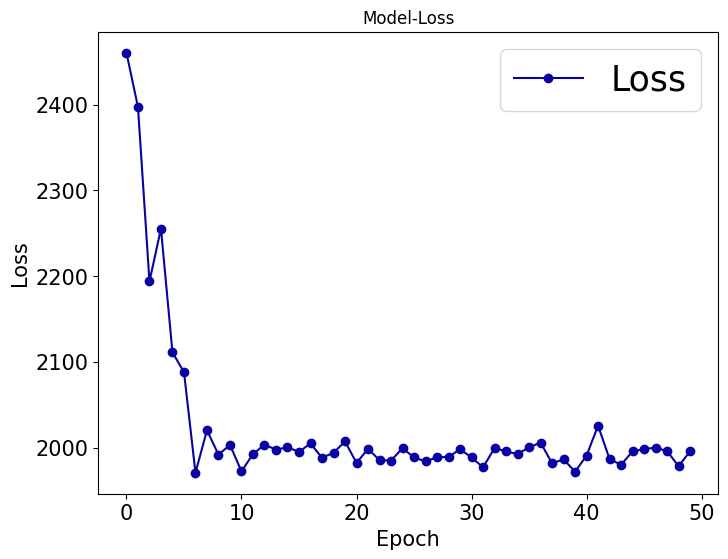

In [32]:
saveLossDiagram(num_epochs,losses,result_dir)

In [33]:
# Specify the path to the saved model checkpoint
model_checkpoint_path = os.path.join(result_dir,'teacher.pth')
# Load the saved model state_dict
model.load_state_dict(torch.load(model_checkpoint_path))

outputss = []
targetss = []

# choose loss to evaluate with 
if loss == 0:
    criterion = nn.MSELoss()
else:
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss

# Evaluate the model on the validation data
with torch.no_grad():
    total_loss = 0
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputss.append(outputs[:,0].tolist())
        targetss.append(targets.tolist())
        loss = criterion(outputs[:,0], targets.float())
        total_loss += loss.item()
    mean_loss = total_loss / len(val_loader)
    if loss == 0:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(result_dir, batch_size, num_epochs, lr, mean_loss, lowest_loss)
    else:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(result_dir, batch_size, num_epochs, lr,lowest_loss, mean_loss)

Batch Size 50 , Epochs 50 , Learning Rate 0.010000 , Loss 1970.753693
MSE Loss: 43.7102
result/teacher\results.csv


In [34]:
outputs = []
for i in outputss:
    for j in i:
        outputs.append(j)

targets = []
for i in targetss:
    for j in i:
        targets.append(j)

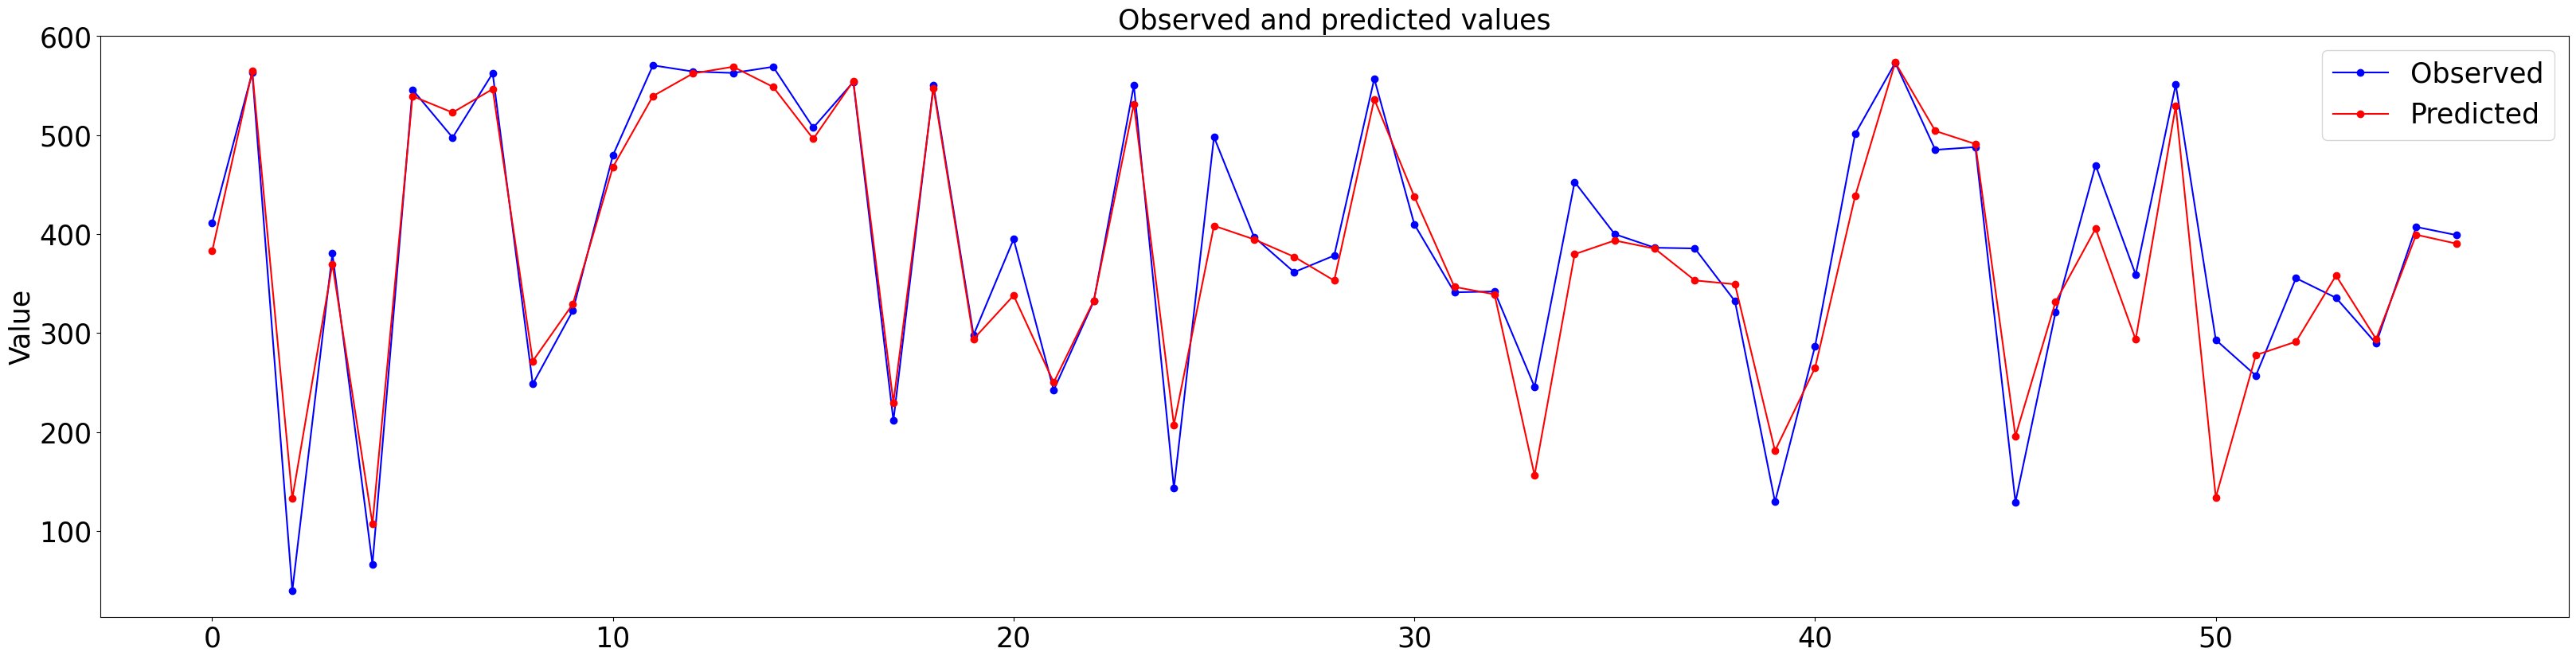

In [35]:
observedvsPredicted(result_dir, targets, outputs)

Train and Shut Down

In [36]:
# import os
# os.system("shutdown /s /t 1")